In [1]:
using Gen, Plots, StatsBase

In [5]:
@gen function roll_model(T::Int)
    rolls = Vector{Float64}(undef, T)
    
    unfair_weighting = {:unfair_weighting} ~ uniform(1.0/6,1)
    weighted_face = {:weighted_face} ~ uniform_discrete(1,6)
    other_faces = Array(1:6)
    filter!(e->e≠weighted_face,other_faces)
    
    die_probs = Vector{Float64}(undef, 6)
    die_probs[1:6] .= (1-unfair_weighting)/5
    die_probs[weighted_face] = unfair_weighting
        
    for i = 1:T
        roll = {(:roll, i)} ~ categorical(die_probs)
        rolls[i] = roll
    end

    # return the rolls
    return rolls
end;

In [22]:
trace = Gen.simulate(roll_model, (10,));
println(get_retval(trace))
println(trace[:unfair_weighting])
println(trace[:weighted_face])
test_traj = get_retval(trace);

[2.0, 5.0, 2.0, 5.0, 1.0, 3.0, 1.0, 2.0, 2.0, 2.0]
0.5626460499859786
2


In [23]:
function do_IS_inference(model, T, rolls, amount_of_computation)
    
    observations = Gen.choicemap()
    for (i, r) in enumerate(rolls)
        observations[(:roll, i)] = r 
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (T,), observations, amount_of_computation);
    return trace
end;

In [24]:
trace_infer = do_IS_inference(roll_model, 10, test_traj, 100000)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##roll_model#276", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:roll, 8) => Gen.ChoiceOrCallRecord{Int64}(2, -0.46079090160909875, NaN, true), (:roll, 9) => Gen.ChoiceOrCallRecord{Int64}(2, -0.46079090160909875, NaN, true), (:roll, 5) => Gen.ChoiceOrCallRecord{Int64}(1, -2.6058128685510167, NaN, true), (:roll, 3) => Gen.ChoiceOrCallRecord{Int64}(2, -0.46079090160909875, NaN, true), (:roll, 6) => Gen.ChoiceOrCallRecord{Int64}(3, -2.6058128685510167, NaN, true), :unfair_weighting => Gen.ChoiceOrCallRecord{Float64}(0.630784559645818, 0.1823215567939546, NaN, true), (:roll, 2) => Gen.ChoiceOrCallRecord{Int64}(5, -2.6058128685510167, NaN, true), (:roll, 1) => Gen.ChoiceOrCallRecord{Int64}(2, -0.46079090160909875, NaN, true), (:roll, 4) => Gen.ChoiceOrCallRecord{Int64}(5, -2.6058128

In [65]:
trace_infer = do_IS_inference(roll_model, 10, test_traj, 100000)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##roll_model#276", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:roll, 8) => Gen.ChoiceOrCallRecord{Int64}(2, -0.5728884428281013, NaN, true), (:roll, 9) => Gen.ChoiceOrCallRecord{Int64}(2, -0.5728884428281013, NaN, true), (:roll, 5) => Gen.ChoiceOrCallRecord{Int64}(1, -2.4393085637989196, NaN, true), (:roll, 3) => Gen.ChoiceOrCallRecord{Int64}(2, -0.5728884428281013, NaN, true), (:roll, 6) => Gen.ChoiceOrCallRecord{Int64}(3, -2.4393085637989196, NaN, true), :unfair_weighting => Gen.ChoiceOrCallRecord{Float64}(0.5638943076504643, 0.1823215567939546, NaN, true), (:roll, 2) => Gen.ChoiceOrCallRecord{Int64}(5, -2.4393085637989196, NaN, true), (:roll, 1) => Gen.ChoiceOrCallRecord{Int64}(2, -0.5728884428281013, NaN, true), (:roll, 4) => Gen.ChoiceOrCallRecord{Int64}(5, -2.4393085637

In [67]:
function do_mcmc_inference(model, obs_rolls, num_iters)

    observations = Gen.choicemap()
    for (i, r) in enumerate(obs_rolls)
        observations[(:roll, i)] = r 
    end
    
    trace, = generate(model, (num_iters,), observations)
    
    fair_vals = Float64[]
    for i=1:num_iters
        trace, = mh(trace, select(:unfair_weighting, :weighted_face))
        push!(fair_vals, trace[:unfair_weighting])
    end
    fair_vals
end

do_mcmc_inference (generic function with 1 method)

In [70]:
chain_out = do_mcmc_inference(roll_model, test_traj, 1000)

1000-element Vector{Float64}:
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 0.6276621541308602
 ⋮
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529
 0.6024139593385529

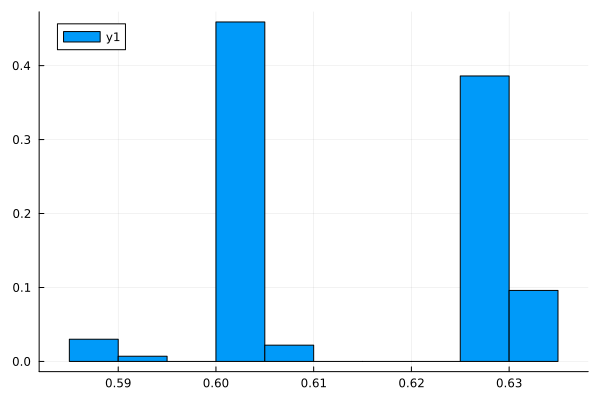

In [71]:
histogram(chain_out, normalize=:probability)

In [72]:
chain_out_long = do_mcmc_inference(roll_model, test_traj, 10000)

10000-element Vector{Float64}:
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 0.5347217797436132
 ⋮
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774
 0.5291227094813774

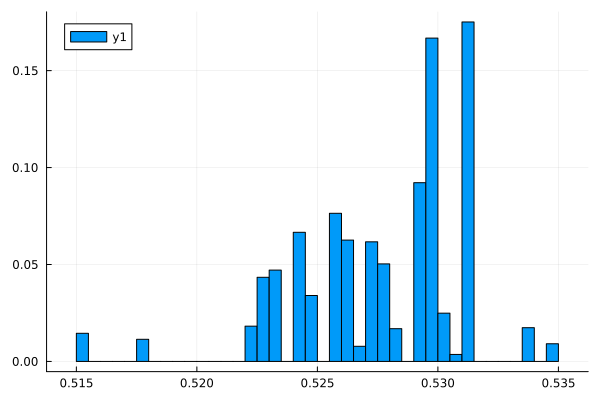

In [73]:
histogram(chain_out_long, normalize=:probability)

In [132]:
@gen function proposal(t, sigma_fair)
    {:unfair_weighting} ~ uniform(max(t[:unfair_weighting] - sigma_fair, 0),min(t[:unfair_weighting] + sigma_fair, 1))
    {:weighted_face} ~ uniform_discrete(1,6)
end

trace, = do_IS_inference(model, size(obs_rolls)[0], obs_rolls, 10000) # mimics burn-in

function do_mcmc_proposal_inference(model, obs_rolls, trace, num_iters)

    observations = Gen.choicemap()
    for (i, r) in enumerate(obs_rolls)
        observations[(:roll, i)] = r 
    end
    
    #trace, = generate(model, (num_iters,), observations)
    
    
    fair_vals = Float64[]
    for i=1:num_iters
        trace, = mh(trace, proposal, (0.05,))
        push!(fair_vals, trace[:unfair_weighting])
    end
    fair_vals
end

do_mcmc_proposal_inference (generic function with 2 methods)

In [82]:
chain_out_prop = do_mcmc_proposal_inference(roll_model, test_traj, 10000)

10000-element Vector{Float64}:
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5465769736203112
 0.5542683887462894
 0.5542683887462894
 0.5542683887462894
 0.5542683887462894
 0.5542683887462894
 ⋮
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267
 0.5557638674654267

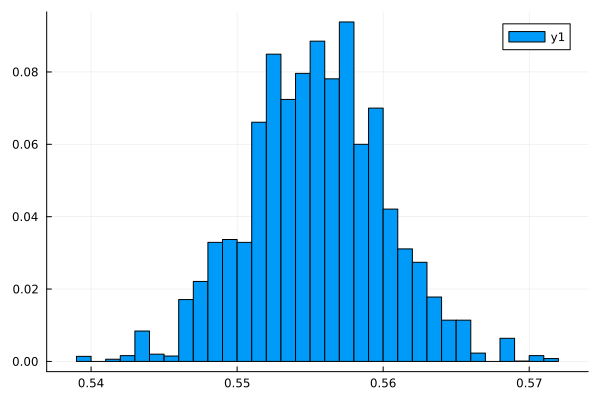

In [83]:
histogram(chain_out_prop, normalize=:probability)

In [151]:
p = histogram(chain_out_prop, normalize=:probability, label="die bias")
xlabel!("Biased face weight")
ylabel!("Probability")
savefig(p,"simulated_die_roll_posterior.png")

"/Users/esli/gen-tracker/simulated_die_roll_posterior.png"

In [109]:
using CSV, DataFrames

In [125]:
fair_faces = CSV.read("faces_roll_noisy.csv", DataFrame)
fair_faces = Matrix(fair_faces)[:,1]
fair_faces.+=1

1000-element Vector{Float64}:
 3.0
 6.0
 2.0
 5.0
 4.0
 3.0
 1.0
 4.0
 1.0
 1.0
 6.0
 6.0
 1.0
 ⋮
 4.0
 2.0
 6.0
 1.0
 2.0
 1.0
 5.0
 2.0
 1.0
 3.0
 2.0
 6.0

In [113]:
unfair_faces = CSV.read("faces_roll_noisy_biased.csv", DataFrame)
unfair_faces = Matrix(unfair_faces)[:,1]
unfair_faces.+=1

1000-element Vector{Float64}:
 6.0
 6.0
 6.0
 1.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 ⋮
 6.0
 6.0
 6.0
 6.0
 2.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0

In [139]:
fair_chain_out = do_mcmc_proposal_inference(roll_model, fair_faces, 2000);

In [156]:
p = histogram(fair_chain_out, normalize=:probability, label="die prob")
xlabel!("Biased face weight")
ylabel!("Probability")
savefig(p,"bullet_fair_die_posterior.png")

"/Users/esli/gen-tracker/bullet_fair_die_posterior.png"

In [145]:
unfair_chain_out = do_mcmc_proposal_inference(roll_model, unfair_faces, 2000);

In [160]:
p = histogram(unfair_chain_out, normalize=:probability, label="die prob")
xlabel!("Biased face weight")
ylabel!("Probability")
savefig(p,"bullet_unfair_die_posterior.png")

"/Users/esli/gen-tracker/bullet_unfair_die_posterior.png"